In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
df = pd.read_csv('proccessed_dataset.csv')

# Giả sử cột nhãn là 'Attack'
X = df.drop(columns=['Label'])
y = df['Label']

# Mã hoá các cột không phải số (nếu có)
X = pd.get_dummies(X, drop_first=True)

In [3]:
num_features = 30  # bạn có thể đổi số này tùy ý, ví dụ 20 hoặc 50
selector = SelectKBest(score_func=f_classif, k=num_features)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print(f"✅ Select top {len(selected_features)} feature:")
print(list(selected_features))

✅ Select top 30 feature:
['Src Port', 'Dst Port', 'Flow Duration', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'FIN Flag Count', 'RST Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Bwd Segment Size Avg', 'Idle Mean', 'Idle Max', 'Idle Min']


c:\Users\acer\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 2 33 35 57 58 59] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\acer\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=42, stratify=y
)

# Chuẩn hoá dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Chuyển sang tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1])

In [6]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

train_losses = []
test_losses = []

for epoch in range(epochs):
    # ----- TRAIN -----
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # ----- EVAL -----
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")


Epoch [5/50] Train Loss: 0.6225 | Test Loss: 0.6075
Epoch [10/50] Train Loss: 0.5631 | Test Loss: 0.5478
Epoch [15/50] Train Loss: 0.5116 | Test Loss: 0.4943
Epoch [20/50] Train Loss: 0.4572 | Test Loss: 0.4379
Epoch [25/50] Train Loss: 0.4012 | Test Loss: 0.3804
Epoch [30/50] Train Loss: 0.3519 | Test Loss: 0.3317
Epoch [35/50] Train Loss: 0.3181 | Test Loss: 0.2997
Epoch [40/50] Train Loss: 0.2991 | Test Loss: 0.2822
Epoch [45/50] Train Loss: 0.2883 | Test Loss: 0.2718
Epoch [50/50] Train Loss: 0.2781 | Test Loss: 0.2631


In [9]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred >= 0.5).float()

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n===== Evaluation Report =====")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


===== Evaluation Report =====
Accuracy : 0.9017
Precision: 0.9349
Recall   : 0.8636
F1-score : 0.8978


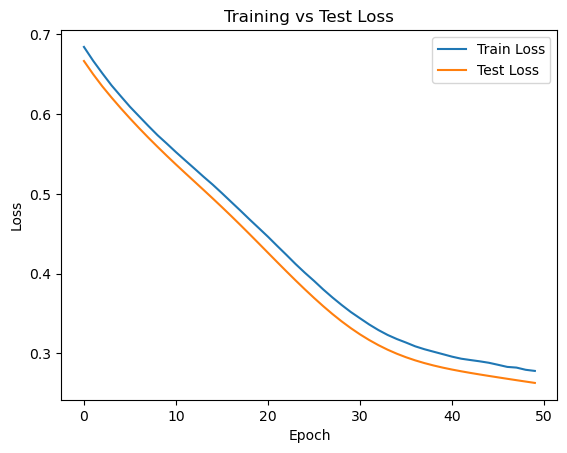

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Test Loss')
plt.show()
